In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# CSV dosyasını oku
VT = pd.read_csv("data/processed_VT_Data.csv")

In [16]:
# Set the pandas option to display all columns when printing the DataFrame
# This ensures that no columns are hidden, which is useful when dealing with wide DataFrames
pd.set_option('display.max_columns',None)

Target Variable

In [19]:
class_counts = VT["Training_Program"].value_counts()
VT_class = pd.DataFrame(class_counts).reset_index()
VT_class.columns = ["Training Program", "Count"]
print(VT_class)

   Training Program  Count
0                 0     33
1                 2     30
2                 3     28
3                 1     26
4                 4     23
5                 5     22
6                 6     15
7                 7     14


In [21]:
class_proportion = VT["Training_Program"].value_counts(normalize=True).round(2)
VT_class_proportion = pd.DataFrame(class_proportion).reset_index()
VT_class.columns = ["Training Program", "Proportion"]
print(VT_class_proportion)

   Training_Program  proportion
0                 0        0.17
1                 2        0.16
2                 3        0.15
3                 1        0.14
4                 4        0.12
5                 5        0.12
6                 6        0.08
7                 7        0.07


Distribution Analysis

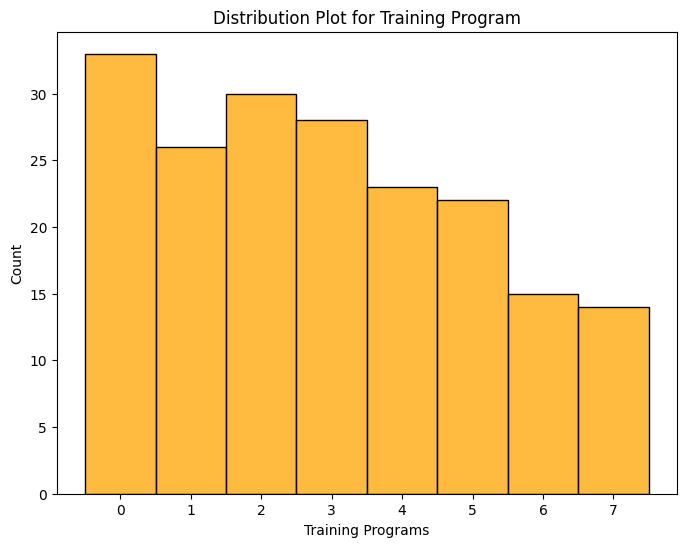

In [28]:
# Training_Program dağılımı için histogram ve KDE
VT['Training_Program'] = VT['Training_Program'].astype('category')
plt.figure(figsize=(8, 6))  
sns.histplot(data=VT, x='Training_Program', kde=False, color='orange')  # KDE çizgisi gerekli değil cunku kategorik degisken
plt.title('Distribution Plot for Training Program')
plt.xlabel('Training Programs')
plt.ylabel('Count')

plt.show()

In [35]:
# Remove the categorical variables 
columns_to_plot = VT.drop(columns=["Training_Program","chronic_conditions","surgeries", "gender", "sports_experience", "goals"]).columns
print(columns_to_plot)

Index(['height', 'weight', 'age', 'resting_pulse', 'body_fat', 'BMI',
       'W/Hip_Ratio', 'W/Height_Ratio', 'shoulder_c', 'chest_c', 'right_arm_c',
       'left_arm_c', 'waist_c', 'hip_c', 'upper_leg_c', 'lower_leg'],
      dtype='object')


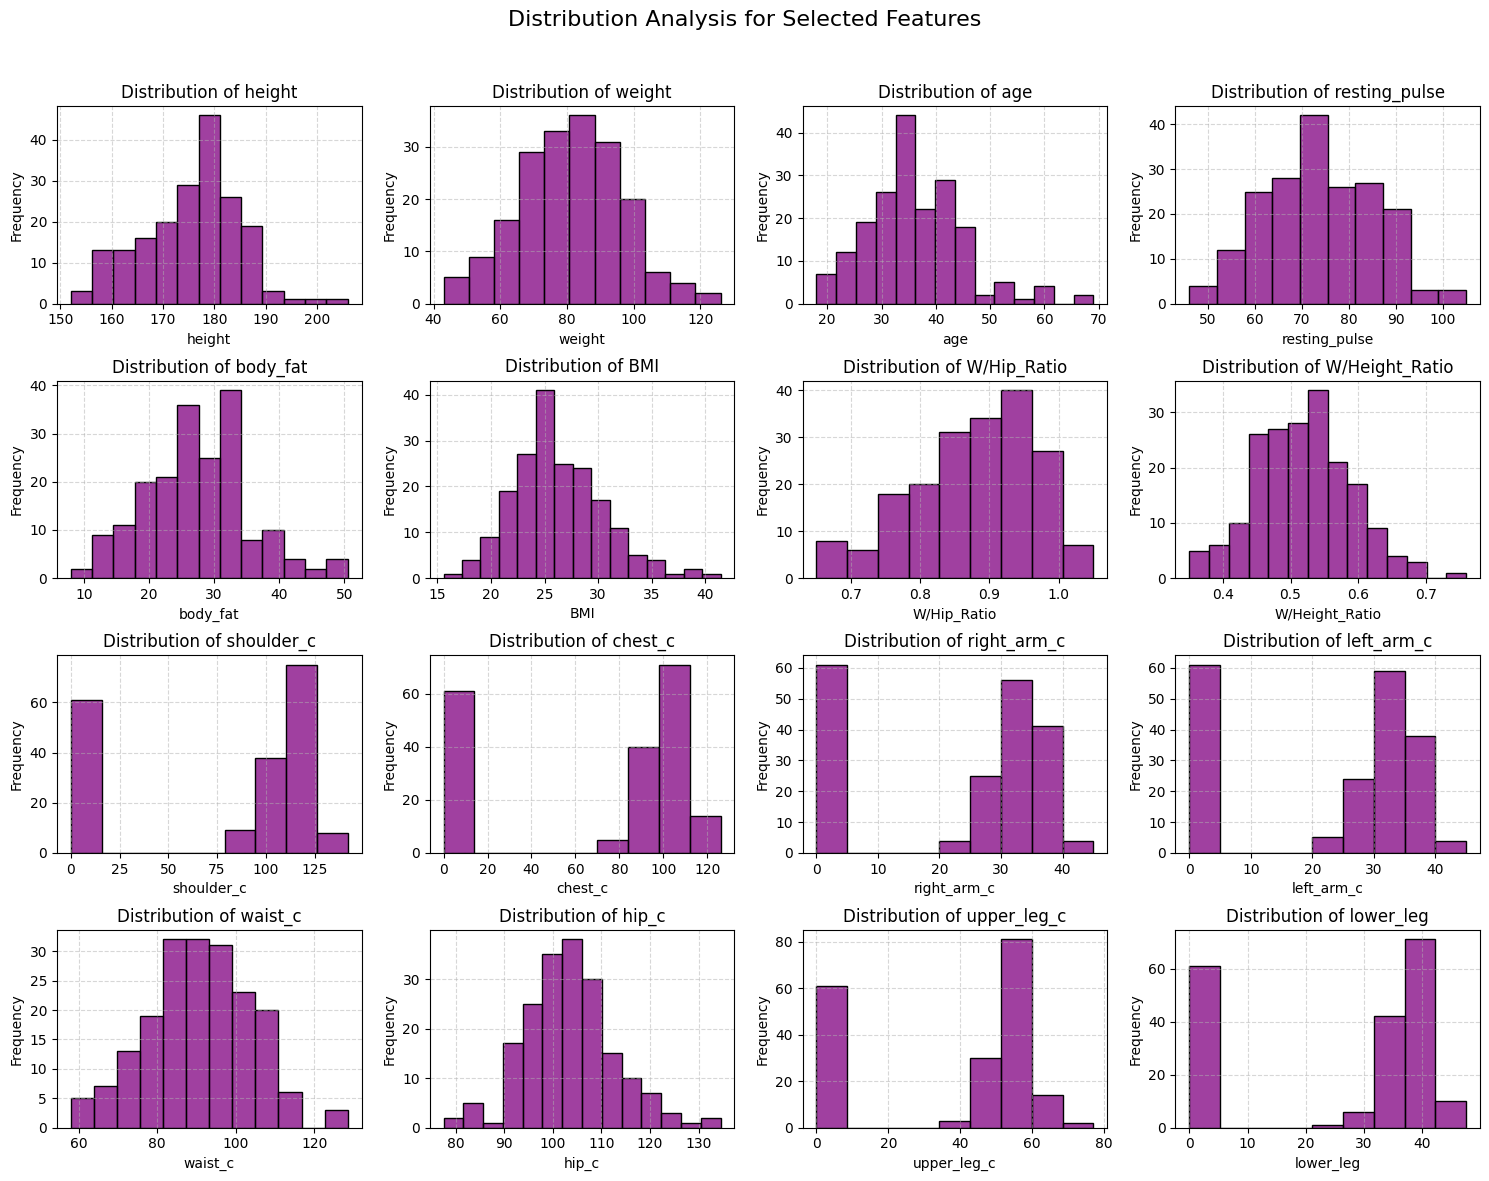

In [73]:
# Calculate the number of rows and columns for the grid of subplots
n_cols = 4  # Number of plots per row
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Number of rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() 

# Her sütun için histogram çizimi
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=VT, x=column, ax=axes[i], kde=False, color='purple')  # KDE'yi isteğe bağlı kullanabilirsiniz
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Boş subplotları kaldır (eğer varsa)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Genel başlık ve düzenlemeler
fig.suptitle('Distribution Analysis for Selected Features', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Genel başlık için üst boşluk
plt.show()

Correlation Analysis

               Feature  Correlation       P-Value  Corrected P-Value  \
0               gender    -0.038208  5.997437e-01       1.000000e+00   
1               height     0.222907  1.938408e-03       4.070657e-02   
2               weight    -0.309692  1.303005e-05       2.736310e-04   
3                  age    -0.119883  9.855559e-02       1.000000e+00   
4        resting_pulse    -0.580217  1.411614e-18       2.964390e-17   
5    sports_experience     0.702857  9.026282e-30       1.895519e-28   
6             body_fat    -0.713077  5.735912e-31       1.204542e-29   
7                goals    -0.421097  1.312143e-09       2.755500e-08   
8                  BMI    -0.520996  1.105544e-14       2.321642e-13   
9          W/Hip_Ratio    -0.241878  7.487715e-04       1.572420e-02   
10      W/Height_Ratio    -0.615675  2.591760e-21       5.442697e-20   
11          shoulder_c    -0.182094  1.169627e-02       2.456217e-01   
12             chest_c    -0.205851  4.277937e-03       8.983667

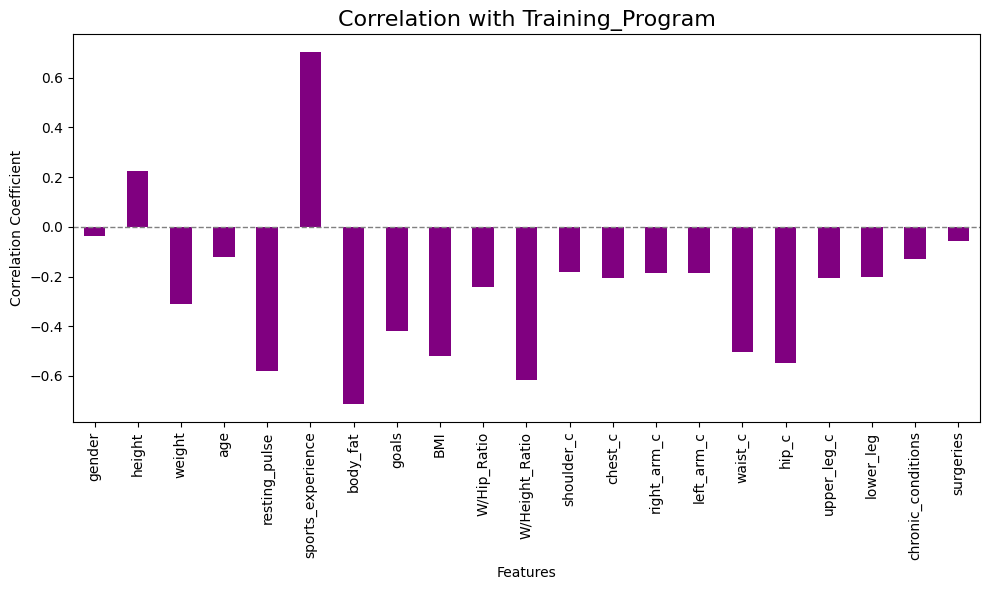

In [219]:
# Hedef değişken ile korelasyon ve p-value hesaplama
correlations = []
p_values = []

# Iterate through each column except the target variable itself
for feature in VT.columns:
    if feature != 'Training_Program':
        corr, p_val = pearsonr(VT['Training_Program'], VT[feature])
        correlations.append((feature, corr))
        p_values.append(p_val)

# Bonferroni düzeltmesi uygulama
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Korelasyonları ve p-values bir DataFrame'e yerleştir
correlation_results = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
correlation_results['P-Value'] = p_values
correlation_results['Corrected P-Value'] = corrected_p_values
correlation_results['Significant'] = correlation_results['Corrected P-Value'] < 0.05

# Sonuçları yazdır
print(correlation_results)

# Görselleştirme
plt.figure(figsize=(10, 6))
correlation_results.set_index('Feature')['Correlation'].plot(kind='bar', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Correlation with Training_Program', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('training_program_correlation.png', dpi=300)
plt.show()

In [8]:
# Read the CSV file
VT = pd.read_csv("data/processed_VT_Data.csv")

# Specify the target variable and independent variables for regression
target_variable = "BMI"
independent_variables = ['height', 'weight', 'body_fat', 'resting_pulse', 
                         'sports_experience', 'W/Height_Ratio', 'waist_c', 'hip_c']

# Create a DataFrame with the independent variables and the target variable
X = VT[independent_variables]
y = VT[target_variable]

# Add a constant term (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the regression model using OLS (Ordinary Least Squares)
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

# Calculate Variance Inflation Factor (VIF) to check for multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3773.
Date:                Tue, 07 Jan 2025   Prob (F-statistic):          7.75e-198
Time:                        22:00:42   Log-Likelihood:                -58.764
No. Observations:                 191   AIC:                             135.5
Df Residuals:                     182   BIC:                             164.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.9298      2.63

Text(0, 0.5, 'Count')

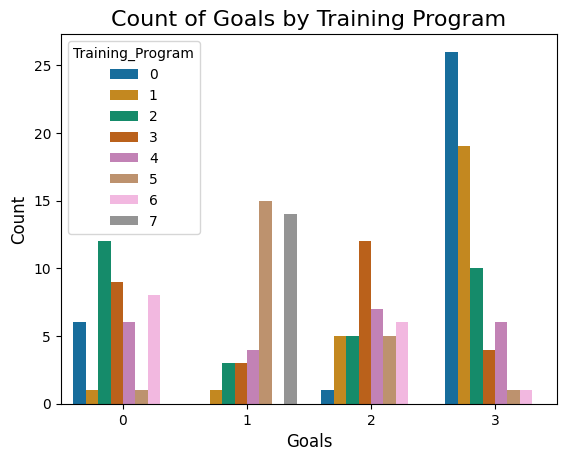

In [211]:
# Countplot for Goals by Training Program with colorblind-friendly palette
sns.countplot(data=VT, x='goals', hue='Training_Program', palette="colorblind")

# Add title and axis labels
plt.title('Count of Goals by Training Program', fontsize=16)
plt.xlabel('Goals', fontsize=12)
plt.ylabel('Count', fontsize=12)

Text(0, 0.5, 'Training Program')

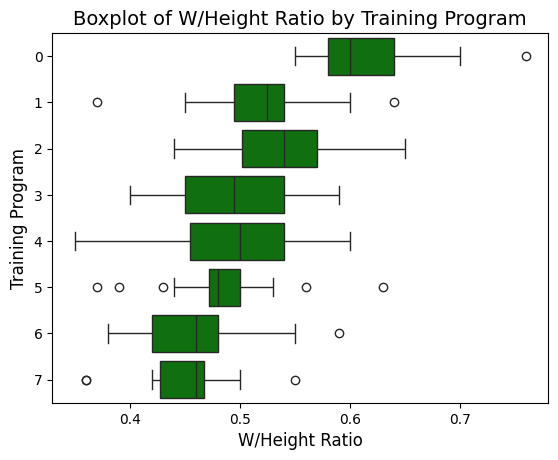

In [139]:
# Boxplot of W/Height Ratio against Training Program
sns.boxplot(data=VT, x='W/Height_Ratio', y='Training_Program',  color= "green")
# Add title and axis labels
plt.title('Boxplot of W/Height Ratio by Training Program', fontsize=14)
plt.xlabel('W/Height Ratio', fontsize=12)
plt.ylabel('Training Program', fontsize=12)

Text(0, 0.5, 'Training Program')

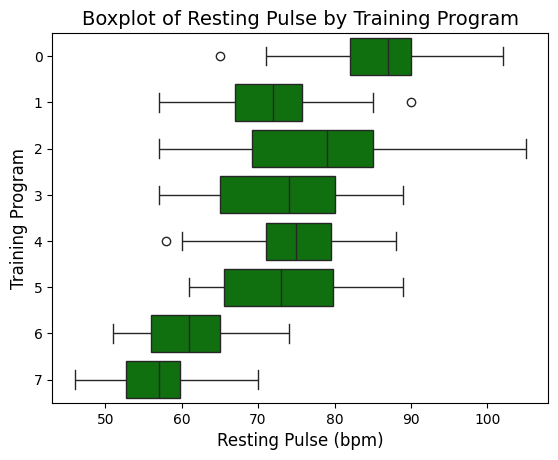

In [209]:
# Boxplot of Resting Pulse by Training Program
sns.boxplot(data=VT, x='resting_pulse', y='Training_Program',  color= "green")
plt.title('Boxplot of Resting Pulse by Training Program', fontsize=14)
plt.xlabel('Resting Pulse (bpm)', fontsize=12)
plt.ylabel('Training Program', fontsize=12)

<Axes: xlabel='W/Height_Ratio', ylabel='resting_pulse'>

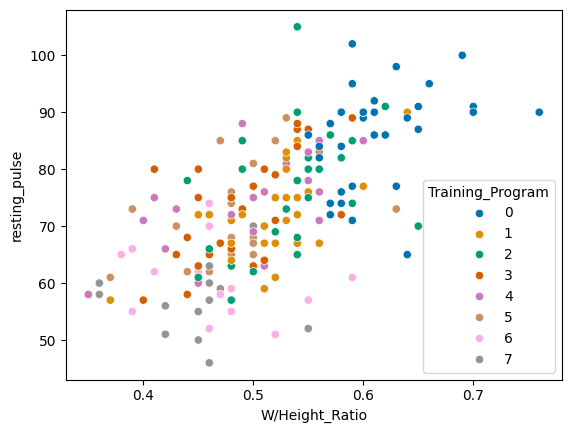

In [121]:
sns.scatterplot(data=VT, x='W/Height_Ratio', y='resting_pulse', hue='Training_Program', palette="colorblind")

Text(0, 0.5, 'Training Program')

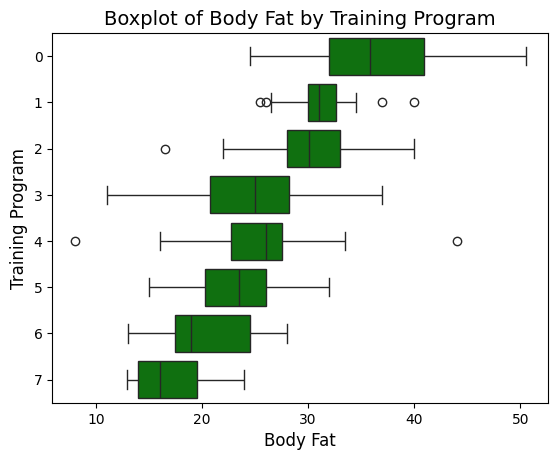

In [205]:
# Boxplot of Body Fat by Training Program
sns.boxplot(data=VT, x='body_fat', y='Training_Program',  color= "green")
plt.title('Boxplot of Body Fat by Training Program', fontsize=14)
plt.xlabel('Body Fat', fontsize=12)
plt.ylabel('Training Program', fontsize=12)

Text(0, 0.5, 'Training Program')

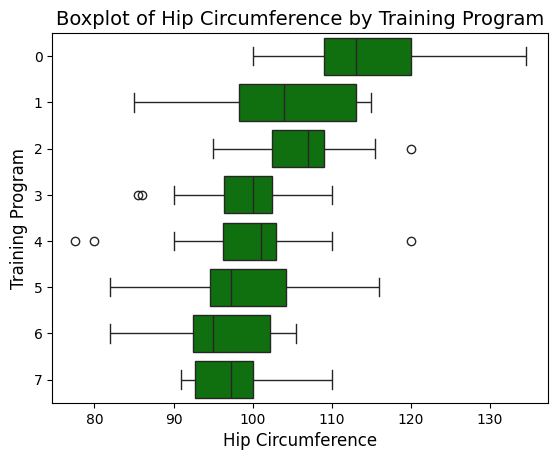

In [229]:
# Boxplot of Hip Circumference by Training Program
sns.boxplot(data=VT, x='hip_c', y='Training_Program',  color= "green")
plt.title('Boxplot of Hip Circumference by Training Program', fontsize=14)
plt.xlabel('Hip Circumference', fontsize=12)
plt.ylabel('Training Program', fontsize=12)

Text(0, 0.5, 'Training Program')

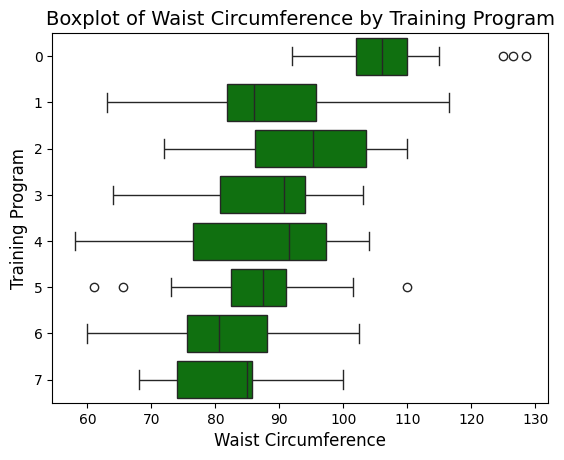

In [201]:
# Boxplot of Waist Circumference by Training Program
sns.boxplot(data=VT, x='waist_c', y='Training_Program',  color= "green")
plt.title('Boxplot of Waist Circumference by Training Program', fontsize=14)
plt.xlabel('Waist Circumference', fontsize=12)
plt.ylabel('Training Program', fontsize=12)

Text(0, 0.5, 'W/Height and W/Hip Ratios')

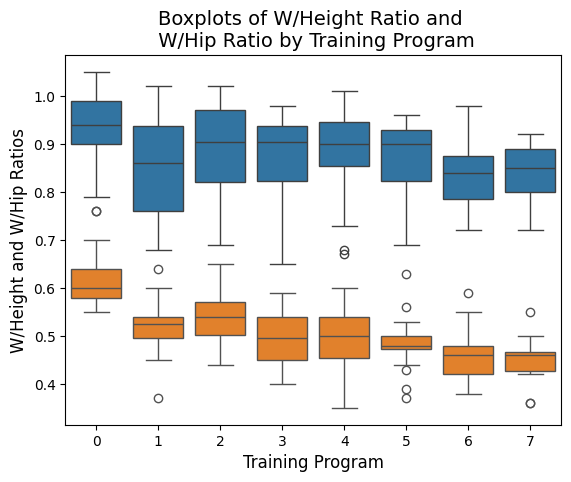

In [199]:
# Boxplot for W/Hip and W/Height Ratios by Training Program
sns.boxplot(data=VT, x='Training_Program', y='W/Hip_Ratio')
sns.boxplot(data=VT, x='Training_Program', y='W/Height_Ratio')
plt.title('Boxplots of W/Height Ratio and \n W/Hip Ratio by Training Program', fontsize=14)
plt.xlabel('Training Program', fontsize=12)
plt.ylabel('W/Height and W/Hip Ratios', fontsize=12)

C:\Users\licop\AppData\Local\Temp\ipykernel_27968\1809675897.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


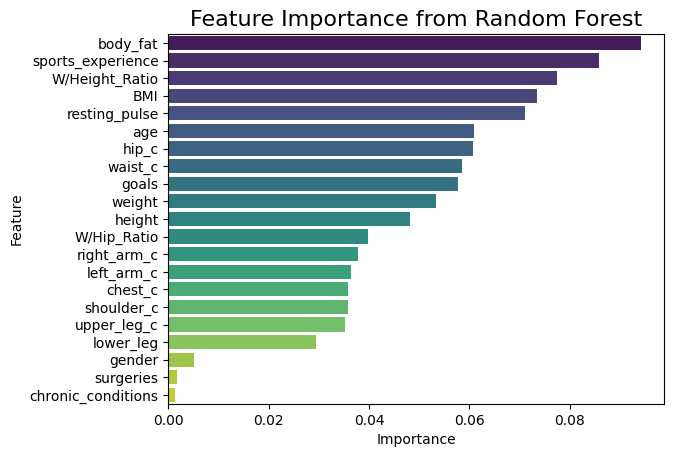

In [233]:
from sklearn.ensemble import RandomForestClassifier
X = VT.drop(columns=['Training_Program'])
y = VT['Training_Program']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.show()


C:\Users\licop\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


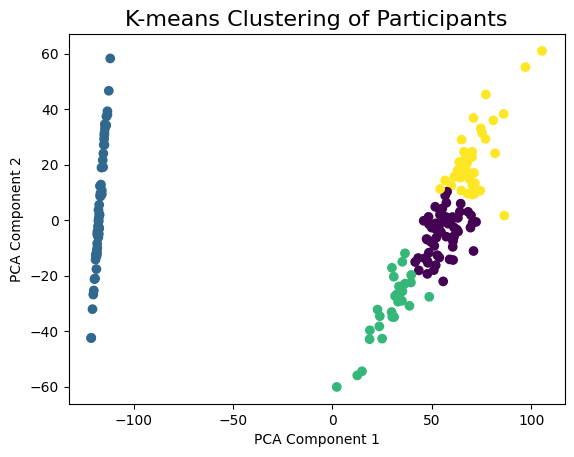

In [235]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualize clusters
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=clusters, cmap='viridis')
plt.title('K-means Clustering of Participants', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


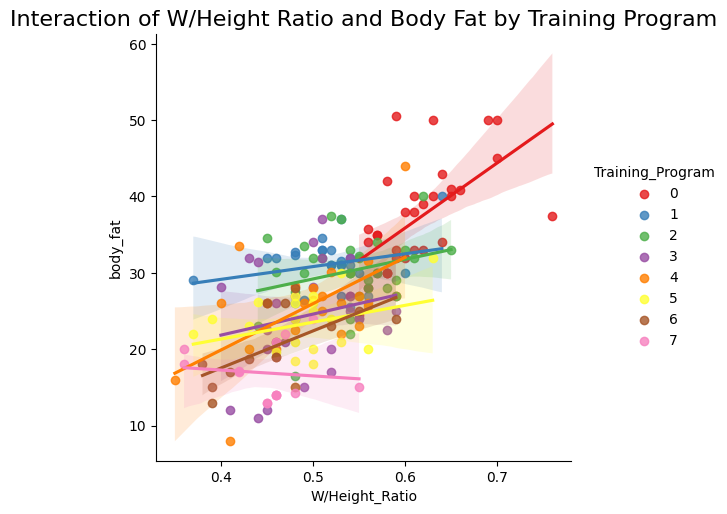

In [239]:
sns.lmplot(data=VT, x='W/Height_Ratio', y='body_fat', hue='Training_Program', scatter=True, palette='Set1')
plt.title('Interaction of W/Height Ratio and Body Fat by Training Program', fontsize=16)
plt.show()


C:\Users\licop\AppData\Local\Temp\ipykernel_27968\723229974.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=VT, x='Training_Program', y='zscore_BMI', palette='coolwarm')


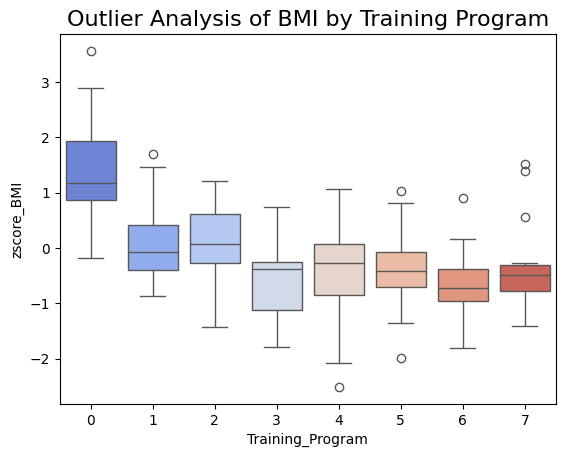

In [241]:
from scipy.stats import zscore
VT['zscore_BMI'] = zscore(VT['BMI'])

sns.boxplot(data=VT, x='Training_Program', y='zscore_BMI', palette='coolwarm')
plt.title('Outlier Analysis of BMI by Training Program', fontsize=16)
plt.show()
